In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2
from torchvision.utils import save_image

# Download and Load Model
- https://pytorch.org/docs/stable/torchvision/models.html#fully-convolutional-networks
- https://pytorch.org/docs/stable/torchvision/models.html#deeplabv3

In [3]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Create Color Palette

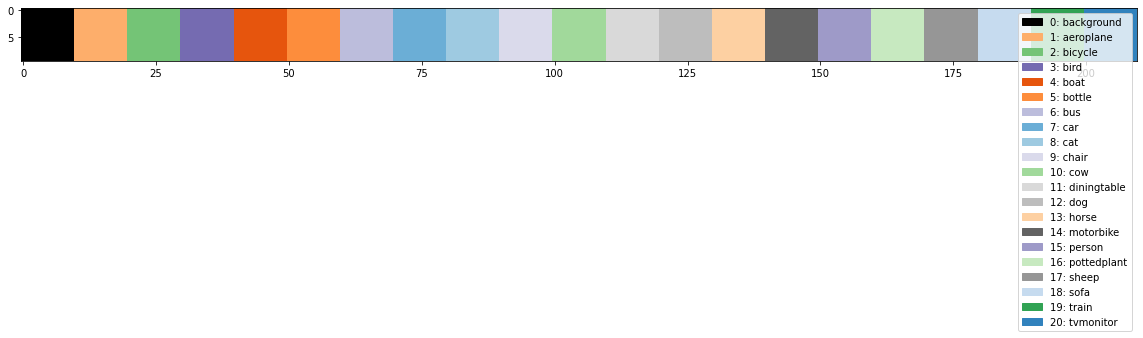

In [5]:
labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

cmap = plt.cm.get_cmap('tab20c')

colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()



np.random.seed(2020)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # background color must be black
colors = np.array(colors, dtype=np.uint8)

palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
    palette_map = np.concatenate([palette_map, c], axis=1)

plt.figure(figsize=(20, 2))
plt.legend(handles=legend)
plt.imshow(palette_map)


# Segment Function

In [6]:
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    output = model(input_batch)['out'][0] # (21, height, width)
    #스칼라로 0 차원이다 

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 
    #numpy 로 가져온다
    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    #numpy로 가져온걸 array로 pillow image로 가져온다 
    r.putpalette(colors)

    return r, output_predictions

In [7]:
img = np.array(Image.open('C:/Study/semantic-segmentation-pytorch-master/imgs/iu_result_2.png').convert('RGB'))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

output = model(input_batch)['aux'][0] # (21, height, width)
#스칼라로 0 차원이다 
print(output.shape)

output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 
#numpy 로 가져온다
r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
#numpy로 가져온걸 array로 pillow image로 가져온다 
r.putpalette(colors)
'''
return r, output_predictions
'''
 

torch.Size([21, 421, 749])


'\nreturn r, output_predictions\n'

# Result

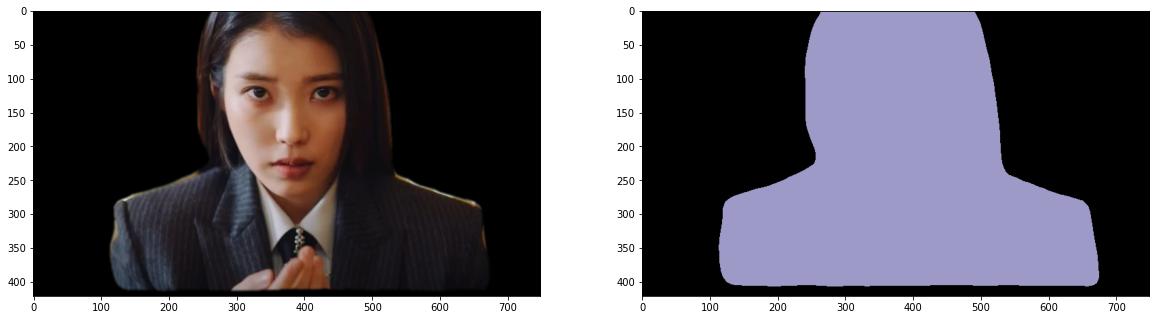

In [18]:
# 이미지 리사이즈 ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ#
# img = cv2.imread('C:/Study/semantic-segmentation-pytorch-master/imgs/name2.jpg') # rgb 이미지 보기

# img = cv2.resize(img, (1000, 500))
# cv2.imwrite('C:/Study/semantic-segmentation-pytorch-master/imgs/name2.png',img)
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ#
img = np.array(Image.open('C:/Study/semantic-segmentation-pytorch-master/imgs/iu_result_2.png').convert('RGB'))


# img = np.array(Image.open('C:/Study/semantic-segmentation-pytorch-master/imgs/name.jpg').convert('RGB'))


fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

# Load Background Image and Resize
- make same size as foreground

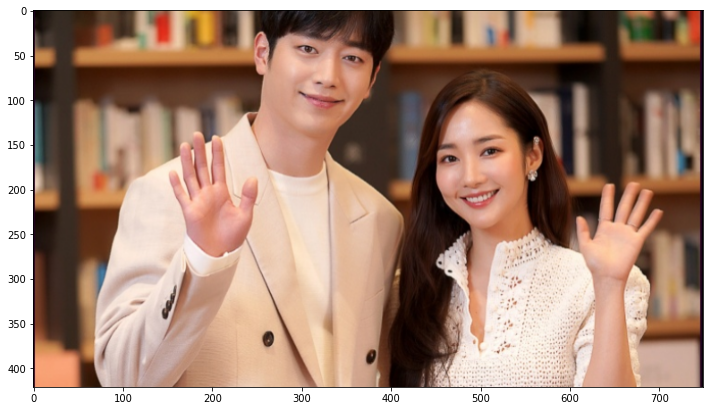

In [19]:
background = np.array(Image.open('C:/Study/semantic-segmentation-pytorch-master/imgs/example.png').convert('RGB'))
bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

# Separate Foreground and Background

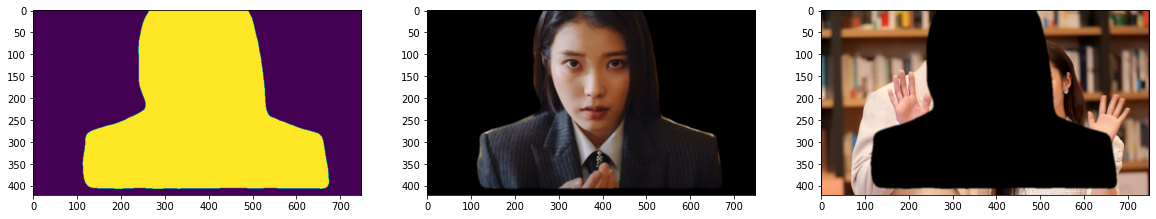

In [20]:
mask = (pred == 15).astype(float) * 255 # 15: person
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
#연산을 하려면 이미지랑 같은 쉐이프를 가져야한다. 
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ#
#사람만
result = foreground.astype(np.uint8)
Image.fromarray(result).save('C:/Study/semantic-segmentation-pytorch-master/imgs/iu_result_123.jpg')
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ#

background = cv2.multiply(1. - alpha, background.astype(float))  
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ#
#배경만
result = background.astype(np.uint8)
Image.fromarray(result).save('C:/Study/semantic-segmentation-pytorch-master/imgs/iu_result_background8.png')
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ#
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

# Result

In [1]:
img = np.array(Image.open('C:/Study/semantic-segmentation-pytorch-master/imgs/HD_iu_result_5.jpg').convert('RGB'))
background = np.array(Image.open('C:/Study/semantic-segmentation-pytorch-master/imgs/HD_iu_result_6.jpg').convert('RGB'))
bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))
result = cv2.add(img, background).astype(np.uint8)
plt.figure(figsize=(12, 12))
plt.imshow(result)

NameError: name 'np' is not defined

# Blur Background

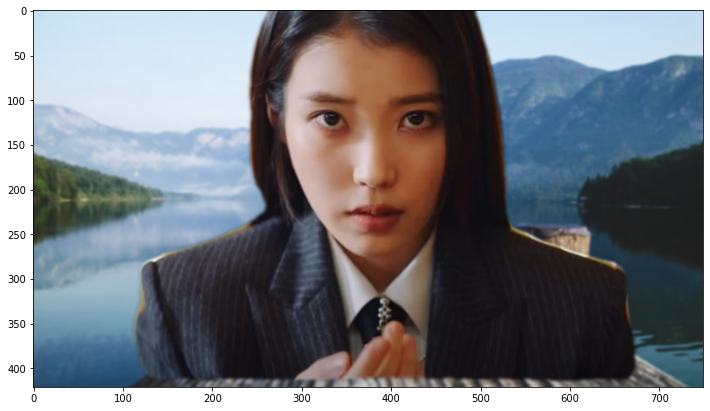

In [24]:
blurred_background = cv2.GaussianBlur(background, (5, 5), 0).astype(float)

bluured_result = cv2.add(foreground, blurred_background).astype(np.uint8)

Image.fromarray(bluured_result).save('C:/Study/semantic-segmentation-pytorch-master/imgs/iu_blur.png')

plt.figure(figsize=(12, 12))
plt.imshow(bluured_result)

# Grayscale Background

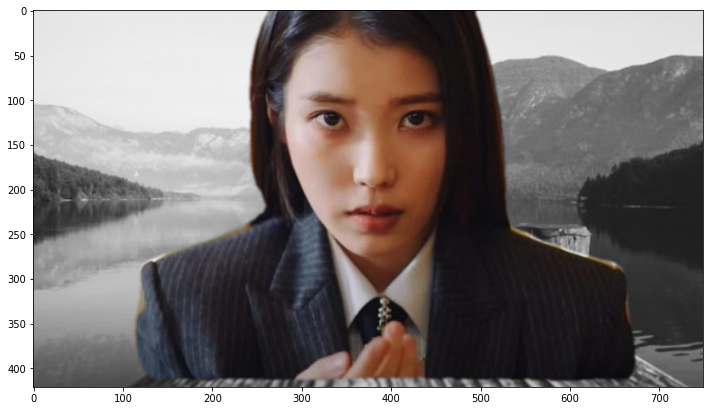

In [25]:
gray_background = cv2.cvtColor(background.astype(np.uint8), cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(gray_background, cv2.COLOR_GRAY2BGR).astype(float)

gray_result = cv2.add(foreground, gray_background).astype(np.uint8)

Image.fromarray(gray_result).save('C:/Study/semantic-segmentation-pytorch-master/imgs/iu_gray.png')

plt.figure(figsize=(12, 12))
plt.imshow(gray_result)

# Other Result

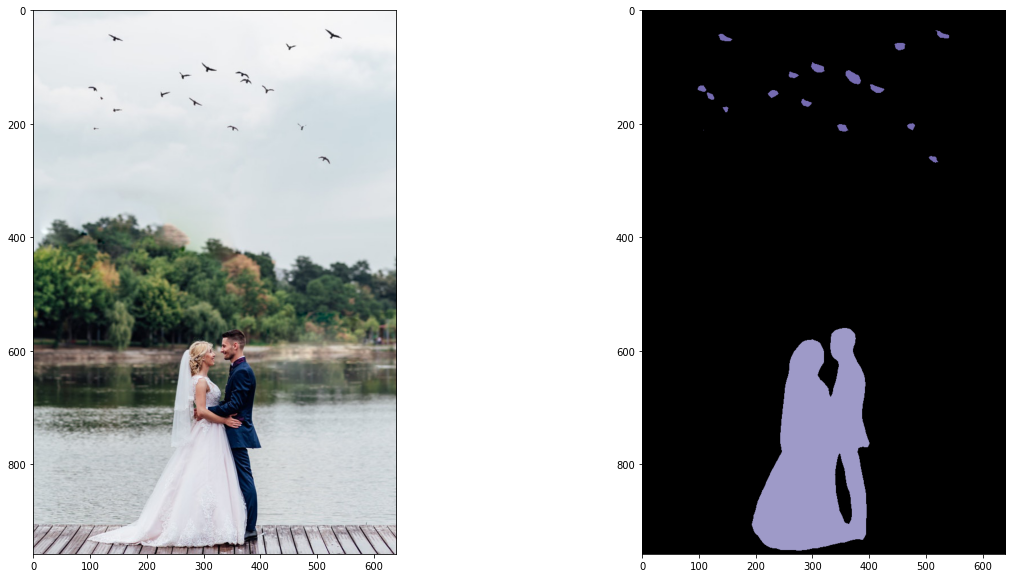

In [26]:
img = np.array(Image.open('C:/Study/semantic-segmentation-pytorch-master/imgs/06.jpg'))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

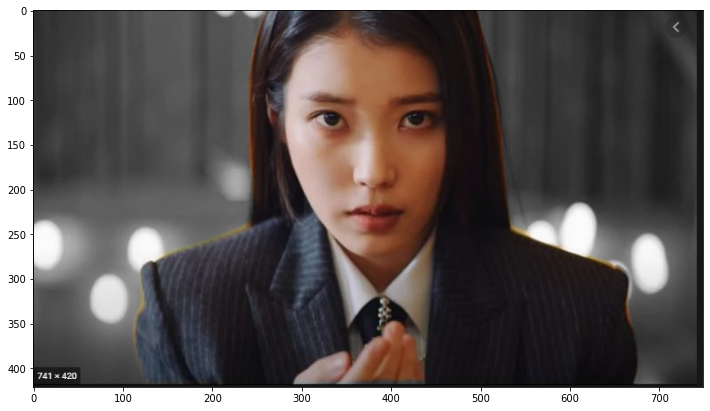

In [28]:
background = np.array(Image.open('C:/Study/semantic-segmentation-pytorch-master/imgs/iu.png'))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

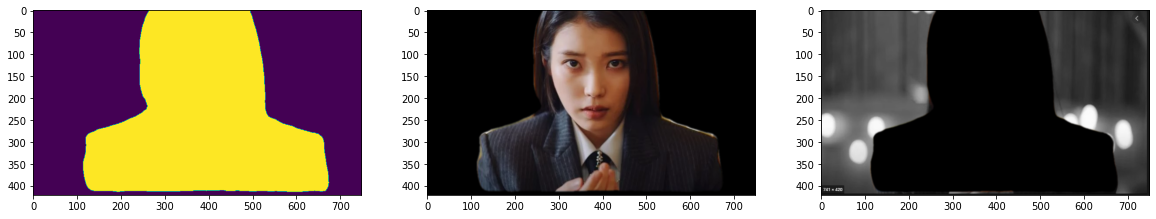

In [13]:
mask = (pred == 15).astype(float) * 255 # 15: person
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

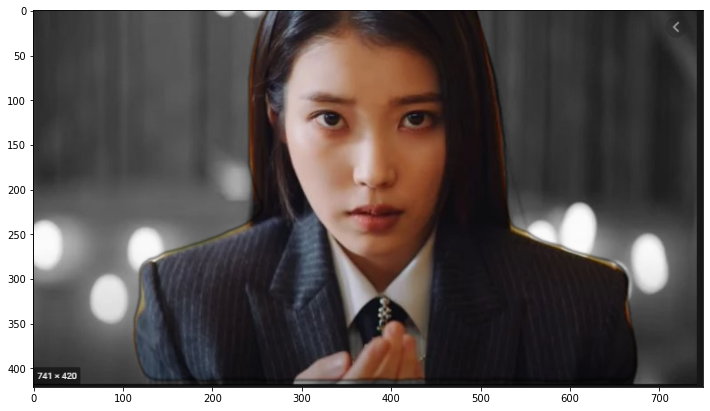

In [35]:
result = cv2.add(foreground, background).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(result)

# Add Birds

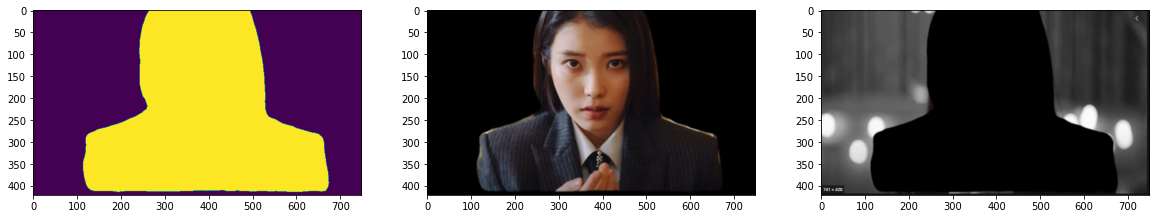

In [14]:
mask = ((pred == 15) | (pred == 3)).astype(float) * 255 # 15: person, 3: bird
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

In [15]:
result = cv2.add(foreground, background).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(result)